# Video Processing

Converting the video into frames for processing

In [ ]:
%cd /content/
import h5py

with h5py.File('0.hdf5', 'r') as f:
    print("Keys in HDF5:", list(f.keys()))

with h5py.File('0.hdf5', 'r') as f:
    for key in ['camera', 'confidences', 'transforms']:
        print(f"\n--- {key} ---")
        if isinstance(f[key], h5py.Group):
            print(f"Sub-keys: {list(f[key].keys())}")
        else:
            print(f"Dataset shape: {f[key].shape}")

/content
Keys in HDF5: ['camera', 'confidences', 'transforms']

--- camera ---
Sub-keys: ['intrinsic']

--- confidences ---
Sub-keys: ['hip', 'leftArm', 'leftForearm', 'leftHand', 'leftIndexFingerIntermediateBase', 'leftIndexFingerIntermediateTip', 'leftIndexFingerKnuckle', 'leftIndexFingerMetacarpal', 'leftIndexFingerTip', 'leftLittleFingerIntermediateBase', 'leftLittleFingerIntermediateTip', 'leftLittleFingerKnuckle', 'leftLittleFingerMetacarpal', 'leftLittleFingerTip', 'leftMiddleFingerIntermediateBase', 'leftMiddleFingerIntermediateTip', 'leftMiddleFingerKnuckle', 'leftMiddleFingerMetacarpal', 'leftMiddleFingerTip', 'leftRingFingerIntermediateBase', 'leftRingFingerIntermediateTip', 'leftRingFingerKnuckle', 'leftRingFingerMetacarpal', 'leftRingFingerTip', 'leftShoulder', 'leftThumbIntermediateBase', 'leftThumbIntermediateTip', 'leftThumbKnuckle', 'leftThumbTip', 'neck1', 'neck2', 'neck3', 'neck4', 'rightArm', 'rightForearm', 'rightHand', 'rightIndexFingerIntermediateBase', 'rightInd

In [ ]:
!mkdir ego_dex_data
import h5py
import numpy as np

with h5py.File('0.hdf5', 'r') as f:
    intrinsics = f['camera']['intrinsic'][:]
    print("Intrinsics extracted. Shape:", intrinsics.shape)
    trajectory = f['transforms']['camera'][:]
    print("Camera trajectory extracted. Shape:", trajectory.shape)

    np.save("ego_dex_data/intrinsics.npy", intrinsics)
    np.save("ego_dex_data/trajectory.npy", trajectory)

Intrinsics extracted. Shape: (3, 3)
Camera trajectory extracted. Shape: (94, 4, 4)


In [ ]:
import cv2
import os

video_path = '0.mp4'
output_folder = 'ego_dex_data/rgb/'
os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(video_path)
count = 0

while count < 94:
    ret, frame = cap.read()
    if not ret:
        break

    file_path = os.path.join(output_folder, f"{count:04d}.jpg")
    cv2.imwrite(file_path, frame)
    count += 1

cap.release()
print(f"Extracted {count} frames to {output_folder}")

Extracted 0 frames to ego_dex_data/rgb/


# Pose Tracking

In [ ]:
%cd /content/
import h5py
import numpy as np
import cv2

H5_FILE = '0.hdf5'
VIDEO_FILE = '0.mp4'
OUTPUT_FILE = '0_pose_estimation.mp4'

FINGER_NAMES = ['Index', 'Middle', 'Ring', 'Little']
SKELETON_MAP = []

def build_hand_map(side):
    """Generates the connectivity list for one hand (left or right)"""
    hand_root = f'{side}Hand'
    connections = []

    connections.append((hand_root, f'{side}ThumbKnuckle'))
    connections.append((f'{side}ThumbKnuckle', f'{side}ThumbIntermediateBase'))
    connections.append((f'{side}ThumbIntermediateBase', f'{side}ThumbIntermediateTip'))
    connections.append((f'{side}ThumbIntermediateTip', f'{side}ThumbTip'))

    for finger in FINGER_NAMES:
        connections.append((hand_root, f'{side}{finger}FingerMetacarpal'))
        connections.append((f'{side}{finger}FingerMetacarpal', f'{side}{finger}FingerKnuckle'))
        connections.append((f'{side}{finger}FingerKnuckle', f'{side}{finger}FingerIntermediateBase'))
        connections.append((f'{side}{finger}FingerIntermediateBase', f'{side}{finger}FingerIntermediateTip'))
        connections.append((f'{side}{finger}FingerIntermediateTip', f'{side}{finger}FingerTip'))

    return connections

SKELETON_CONNECTIONS = build_hand_map('left') + build_hand_map('right')

def project_point(world_pos, cam_pose, K):
    """projects 3D world coord to 2D pixels"""
    view_matrix = np.linalg.inv(cam_pose)
    point_h = np.append(world_pos, 1) 
    point_cam = view_matrix @ point_h

    if point_cam[2] <= 0: return None

    pixel_coords_homo = K @ point_cam[:3]

    u = int(pixel_coords_homo[0] / pixel_coords_homo[2])
    v = int(pixel_coords_homo[1] / pixel_coords_homo[2])
    return (u, v)

with h5py.File(H5_FILE, 'r') as f:
    K = f['camera']['intrinsic'][:]

    cap = cv2.VideoCapture(VIDEO_FILE)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(OUTPUT_FILE, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    print("Drawing Skeleton...")

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_idx >= 94: break

        cam_pose = f['transforms']['camera'][frame_idx]

        for start_joint, end_joint in SKELETON_CONNECTIONS:
            if start_joint in f['transforms'] and end_joint in f['transforms']:

                p1_3d = f['transforms'][start_joint][frame_idx][:3, 3]
                p2_3d = f['transforms'][end_joint][frame_idx][:3, 3]

                pt1 = project_point(p1_3d, cam_pose, K)
                pt2 = project_point(p2_3d, cam_pose, K)

                if pt1 and pt2:
                    color = (0, 255, 0)
                    cv2.line(frame, pt1, pt2, color, 2)
                    cv2.circle(frame, pt2, 4, (255, 100, 0), -1)

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"Skeleton video saved to {OUTPUT_FILE}")

/content
Drawing Skeleton...
Skeleton video saved to 0_pose_estimation.mp4


# Camera Trajectory

In [ ]:
%cd /content/
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob

def generate_all_3d_paths(base_path="./", output_folder="video_learning_samples"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    tasks = ['add_remove_lid', 'basic_pick_and_place']

    for task in tasks:
        task_path = os.path.join(base_path, task)
        if not os.path.exists(task_path): continue

        print(f"Generating 3D paths for: {task}")
        h5_files = glob.glob(os.path.join(task_path, "*.hdf5"))

        fig_task = plt.figure(figsize=(10, 8))
        ax_task = fig_task.add_subplot(111, projection='3d')

        for h5_file in h5_files:
            file_id = os.path.splitext(os.path.basename(h5_file))[0]
            with h5py.File(h5_file, 'r') as h5:
                cam_poses = h5['transforms/camera'][()]
                pos = cam_poses[:, :3, 3]

                fig_ind = plt.figure(figsize=(8, 6))
                ax_ind = fig_ind.add_subplot(111, projection='3d')
                ax_ind.plot(pos[:, 0], pos[:, 2], pos[:, 1], color='blue', lw=2)
                ax_ind.scatter(pos[0,0], pos[0,2], pos[0,1], color='green', s=100, label='Start')
                ax_ind.scatter(pos[-1,0], pos[-1,2], pos[-1,1], color='red', s=100, label='End')
                ax_ind.set_title(f"3D Path: {task} (Video {file_id})")
                ax_ind.set_xlabel('X (meters)')
                ax_ind.set_ylabel('Z (meters)')
                ax_ind.set_zlabel('Y (meters)')
                ax_ind.legend()

                plt.savefig(os.path.join(output_folder, f"{task}_{file_id}_3d_path.png"))
                plt.close()

                ax_task.plot(pos[:, 0], pos[:, 2], pos[:, 1], alpha=0.5, label=f"Trial {file_id}")

        ax_task.set_title(f"Generalized Trajectory: {task} (All Trials)")
        ax_task.set_xlabel('X (m)')
        ax_task.set_ylabel('Z (m)')
        ax_task.set_zlabel('Y (m)')
        plt.close()

generate_all_3d_paths("video_learning_samples")

/content
Generating 3D paths for: add_remove_lid
Generating 3D paths for: basic_pick_and_place


In [ ]:
import shutil
from google.colab import files

folder_to_download = "/content/video_learning_samples"
zip_filename = "/content/video_learning_samples.zip"

print(f"Zipping '{folder_to_download}'...")
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_to_download)

print("Starting download...")
files.download(zip_filename)

📦 Zipping '/content/video_learning_samples'...
⬇️ Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PyTorch3D Installation

In [ ]:
import os
import sys

print("🔧 Installing PyTorch3D (This takes ~5 minutes)...")

!pip install fvcore iopath

os.environ['CPLUS_INCLUDE_PATH'] = "/usr/include/eigen3"
os.environ['TORCH_CUDA_ARCH_LIST'] = "8.0"
!pip install "git+https://github.com/facebookresearch/pytorch3d.git" --no-build-isolation

print("✅ PyTorch3D Installed.")

🔧 Installing PyTorch3D (This takes ~5 minutes)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=57534dce78f467d174274287208276323f11a2acb4d9bbaf5efe383fa46e0243
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=7a369be05dbd0e922a774e7555398947e62429086915b200e5f7e227eb7b1468
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-oypz1c7d
  Running command git clone --filter=blob:none --quiet h

# For Foundation Pose -

Creating the masks, depth and obj file and creating the 6D tracking.

In [ ]:
import os
import torch

!pip install -e "git+https://github.com/facebookresearch/segment-anything-2.git#egg=sam_2"

!wget -P ./checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt

Obtaining sam_2 from git+https://github.com/facebookresearch/segment-anything-2.git#egg=sam_2
  Cloning https://github.com/facebookresearch/segment-anything-2.git to ./src/sam-2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /content/src/sam-2
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.4 MB/s eta 0:00:00
  Building editable for sam_2 (pyproject.toml) ... done
  Created wheel for sam_2: filename=sam_2-1.0-0.editable-py3-none-any.whl size=13847 sha256=5dbd42b569c

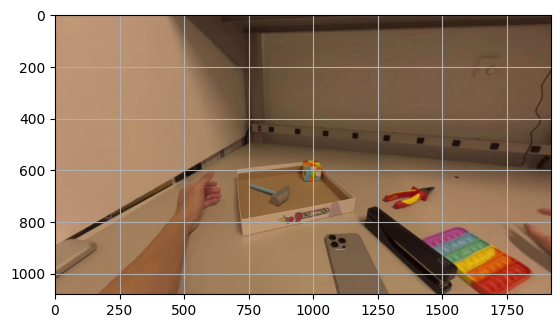

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("ego_dex_data/rgb/0000.jpg")
plt.imshow(img)
plt.grid(True) # find the X and Y coordinates of the object for input in the next part
plt.show()

In [ ]:
import sys
import os

sys.path.append("/content/src/sam-2")

try:
    from sam2.build_sam import build_sam2_video_predictor
    print("SAM 2 imported successfully!")
except ModuleNotFoundError:
    print("Still not found. Restarting session...")
    os.kill(os.getpid(), 9)


import numpy as np
from sam2.build_sam import build_sam2_video_predictor

checkpoint = "./checkpoints/sam2_hiera_base_plus.pt"
model_cfg = "sam2_hiera_b+.yaml" 
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

inference_state = predictor.init_state(video_path="ego_dex_data/rgb")

points = np.array([[1300, 900]], dtype=np.float32) #change x,y depending on the plot above.
labels = np.array([1], dtype=np.int32)

_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=0,
    obj_id=1,
    points=points,
    labels=labels,
)

video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

import cv2
os.makedirs("ego_dex_data/masks", exist_ok=True)

for frame_idx, obj_masks in video_segments.items():
    mask_img = (obj_masks[1][0] * 255).astype(np.uint8)
    cv2.imwrite(f"ego_dex_data/masks/{frame_idx:04d}.jpg", mask_img)

print("Successfully generated 94 masks!")

SAM 2 imported successfully!


frame loading (JPEG): 100%|██████████| 94/94 [00:04<00:00, 19.61it/s]
/content/src/sam-2/sam2/sam2_video_predictor.py:786: UserWarning: /content/src/sam-2/sam2/_C.so: undefined symbol: _ZNK3c1010TensorImpl15incref_pyobjectEv

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s]


Successfully generated 94 masks!


In [ ]:
!pip install timm==0.6.7
!pip install h5py tqdm

import os
if not os.path.exists('ZoeDepth'):
    !git clone https://github.com/isl-org/ZoeDepth.git

import sys
sys.path.append('/content/ZoeDepth')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.24
    Uninstalling timm-1.0.24:
      Successfully uninstalled timm-1.0.24
Cloning into 'ZoeDepth'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 114 (delta 40), reused 23 (delta 23), pack-reused 42 (from 2)
Receiving objects: 100% (114/114), 4.09 MiB | 36.76 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
import numpy as np
import h5py

with h5py.File('0.hdf5', 'r') as f:
    raw_intrinsics = f['camera']['intrinsic'][:]

    if raw_intrinsics.shape == (3, 3):
        K = raw_intrinsics
    elif raw_intrinsics.size == 4:
        fx, fy, cx, cy = raw_intrinsics
        K = np.array([
            [fx, 0,  cx],
            [0,  fy, cy],
            [0,  0,  1 ]
        ])
    else:
        K = raw_intrinsics

    np.savetxt("ego_dex_data/cam_K.txt", K)
    print("Formatted K matrix saved to cam_K.txt")

Formatted K matrix saved to cam_K.txt


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import glob

RGB_DIR = '/content/ego_dex_data/rgb'
MASK_DIR = '/content/ego_dex_data/masks'
DEPTH_OUT_DIR = '/content/ego_dex_data/depth'
os.makedirs(DEPTH_OUT_DIR, exist_ok=True)

print("Loading ZoeDepth model...")
model_zoe = torch.hub.load("isl-org/ZoeDepth", "ZoeD_N", pretrained=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_zoe = model_zoe.to(device).eval()

rgb_files = sorted(glob.glob(os.path.join(RGB_DIR, "*")))
mask_files = sorted(glob.glob(os.path.join(MASK_DIR, "*")))

if len(rgb_files) != len(mask_files):
    print(f"Warning: Found {len(rgb_files)} RGB images but {len(mask_files)} masks!")

print(f"Starting depth generation for {len(rgb_files)} frames...")

for i in tqdm(range(len(rgb_files))):
    rgb_img = Image.open(rgb_files[i]).convert("RGB")

    mask_img = Image.open(mask_files[i]).convert("L")
    mask_np = np.array(mask_img)

    with torch.no_grad():
        depth_meters = model_zoe.infer_pil(rgb_img)

    depth_mm = (depth_meters * 1000).clip(0, 65535).astype(np.uint16)
    depth_mm[mask_np < 128] = 0

    file_name = os.path.basename(rgb_files[i]).split('.')[0] + ".png"
    out_path = os.path.join(DEPTH_OUT_DIR, file_name)
    Image.fromarray(depth_mm).save(out_path)

print(f"Done! Depth files saved to {DEPTH_OUT_DIR}")

Loading ZoeDepth model...


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/isl-org/ZoeDepth/zipball/main" to /root/.cache/torch/hub/main.zip
img_size [384, 512]


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Downloading: "https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt" to /root/.cache/torch/hub/checkpoints/ZoeD_M12_N.pt


100%|██████████| 1.34G/1.34G [00:07<00:00, 204MB/s]


Loaded successfully
Starting depth generation for 94 frames...


100%|██████████| 94/94 [00:35<00:00,  2.63it/s]

Done! Depth files saved to /content/ego_dex_data/depth


In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 136.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
%cd /content/
!rm -r FoundationPose

!git clone https://github.com/NVlabs/FoundationPose.git
%cd FoundationPose

!pip install pycuda transforms3d trimesh scikit-video
!pip install timm==0.6.7

/content
Cloning into 'FoundationPose'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233 (from 1)
Receiving objects: 100% (233/233), 120.80 MiB | 41.08 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/FoundationPose
  Using cached pycuda-2026.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2026.1-cp312-cp312-linux_x86_64.whl size=659448 sha256=c7b99a2b0f149c729bbae86eb1c621f5287c31246

In [ ]:
import shutil
import os

# making the exact folder structure needed for foundation pose demo run
target_dir = "/content/FoundationPose/demo_data/my_object"
os.makedirs(target_dir, exist_ok=True)

shutil.copytree("/content/ego_dex_data/rgb", f"{target_dir}/rgb")
shutil.copytree("/content/ego_dex_data/depth", f"{target_dir}/depth")
shutil.copytree("/content/ego_dex_data/masks", f"{target_dir}/masks")

shutil.copy("/content/ego_dex_data/cam_K.txt", f"{target_dir}/cam_K.txt")

'/content/FoundationPose/demo_data/my_object/cam_K.txt'

In [ ]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

refiner_src = '/content/drive/MyDrive/no_diffusion/2023-10-28-18-33-37'
refiner_dst = '/content/FoundationPose/weights/2023-10-28-18-33-37'

os.makedirs(refiner_dst, exist_ok=True)

if os.path.exists(refiner_src):
    shutil.copy(f"{refiner_src}/model_best.pth", f"{refiner_dst}/model_best.pth")
    shutil.copy(f"{refiner_src}/config.yml", f"{refiner_dst}/config.yml")
    print("Refiner weights and config successfully copied!")
else:
    print("Error: Could not find the refiner folder in your Drive. Did you add the shortcut?")

Mounted at /content/drive
✅ Refiner weights and config successfully copied!


In [ ]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

scorer_src = '/content/drive/MyDrive/no_diffusion/2024-01-11-20-02-45'
scorer_dst = '/content/FoundationPose/weights/2024-01-11-20-02-45'

os.makedirs(scorer_dst, exist_ok=True)

if os.path.exists(scorer_src):
    shutil.copy(f"{scorer_src}/model_best.pth", f"{scorer_dst}/model_best.pth")
    shutil.copy(f"{scorer_src}/config.yml", f"{scorer_dst}/config.yml")
    print("Scorer weights and config successfully copied!")
else:
    print("Error: Could not find the scorer folder in your Drive. Did you add the shortcut?")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ scorer weights and config successfully copied!


In [ ]:
import open3d as o3d
import numpy as np
import cv2
import os
import glob

RGB_DIR = '/content/ego_dex_data/rgb'
DEPTH_DIR = '/content/ego_dex_data/depth'
MASK_DIR = '/content/ego_dex_data/masks'
K_PATH = '/content/FoundationPose/demo_data/my_object/cam_K.txt'

idx = 0

def get_file_at_index(directory, index, ext_list):
    for ext in ext_list:
        f = sorted(glob.glob(os.path.join(directory, f"*.{ext}")))
        if len(f) > index: return f[index]
    return None

rgb_path = get_file_at_index(RGB_DIR, idx, ["jpg", "png"])
depth_path = get_file_at_index(DEPTH_DIR, idx, ["png", "jpg"])
mask_path = get_file_at_index(MASK_DIR, idx, ["jpg", "png"])

print(f"Processing Single Frame (Index {idx})...")

color = o3d.io.read_image(rgb_path)
depth_raw = cv2.imread(depth_path, -1) 
mask = cv2.imread(mask_path, 0)

depth_raw[mask < 100] = 0
depth = o3d.geometry.Image(depth_raw)

K_orig = np.loadtxt(K_PATH)
intrinsic = o3d.camera.PinholeCameraIntrinsic(1920, 1080, K_orig[0,0], K_orig[1,1], K_orig[0,2], K_orig[1,2])

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color, depth,
    depth_scale=1000.0,
    depth_trunc=3.0,
    convert_rgb_to_intensity=False
)


volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=0.002,
    sdf_trunc=0.01,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8
)


identity_pose = np.eye(4)
volume.integrate(rgbd, intrinsic, np.linalg.inv(identity_pose))

mesh = volume.extract_triangle_mesh()
filename = "/content/FoundationPose/demo_data/my_object/mesh.obj"

if not mesh.is_empty():
    mesh.remove_degenerate_triangles()
    mesh.remove_duplicated_vertices()

    mesh.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    o3d.io.write_triangle_mesh(filename, mesh)
    print(f"SUCCESS! Saved {filename}")
else:
    print("Error: Mesh is empty. Check your mask.")

Processing Single Frame (Index 0)...
SUCCESS! Saved /content/FoundationPose/demo_data/my_object/mesh.obj


In [ ]:
!ls /content/FoundationPose/demo_data/my_object/

!sudo apt-get update
!sudo apt-get install -y libegl1-mesa-dev libgl1-mesa-dev libgles2-mesa-dev

!pip install ninja

!pip install --upgrade pip setuptools wheel

import torch
import os

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if not torch.cuda.is_available():
    print("\nCRITICAL ERROR: You are running on CPU.")
    print("Action: Go to 'Runtime' -> 'Change runtime type' -> Select 'T4 GPU' (or A100).")
else:
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    os.environ['CUDA_HOME'] = '/usr/local/cuda'
    print("CUDA_HOME set to /usr/local/cuda")

print("Installing nvdiffrast... (This may take a minute)")
!pip install git+https://github.com/NVlabs/nvdiffrast.git --no-build-isolation

print("DONE! nvdiffrast installed successfully.")
!pip install trimesh yacs pyyaml

cam_K.txt  depth  masks  mesh.obj  rgb
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:13 h

PyTorch Version: 2.9.0+cu126
CUDA Available: True
✅ GPU Detected: NVIDIA A100-SXM4-80GB
CUDA_HOME set to /usr/local/cuda
Installing nvdiffrast... (This may take a minute)
  Cloning https://github.com/NVlabs/nvdiffrast.git to /tmp/pip-req-build-jusr2izc
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast.git /tmp/pip-req-build-jusr2izc
  Resolved https://github.com/NVlabs/nvdiffrast.git to commit 253ac4fcea7de5f396371124af597e6cc957bfae
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvdiffrast: filename=nvdiffrast-0.4.0-cp312-cp312-linux_x86_64.whl size=16595091 sha256=cf1b0d6541f5260ea94dd6ef7a869396349b571c7169a97d464a885c7d9959e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-8onx5k5m/wheels/d1/82/ea/91b5b9219953f7784a69f9e8d2dacad80beb8a99a5e46af62e
Successfully built nvdiffrast
DONE! nvdiffrast installed successfully.


In [ ]:
!pip install transformations==2024.6.1 \
             kornia==0.7.2 \
             einops==0.7.0 \
             warp-lang==1.0.2 \
             roma==1.4.4 \
             pysdf==0.1.9 \
             trimesh==4.2.2 \
             pyglet==1.5.28 \
             omegaconf \
             hydra-core

print("Installed missing dependencies.")

✅ Installed missing dependencies.


In [ ]:
!pip install "numpy<2.0" "ruamel.yaml"

print("Dependencies patched.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 29.1 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [numpy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tobler 0

✅ Dependencies patched.


In [ ]:
import os
import sys
import shutil
import glob
import subprocess

print("STARTING BULLDOZER SETUP (Ignoring failures)...")
base_dir = '/content/FoundationPose'
os.chdir(base_dir)

print("Installing System Libraries...")
subprocess.run("sudo apt-get update -qq", shell=True)
subprocess.run("sudo apt-get install -y -qq libeigen3-dev libboost-all-dev libgl1-mesa-dev", shell=True)

print("Installing requirements one by one...")
with open('requirements.txt', 'r') as f:
    lines = f.readlines()

for line in lines:
    line = line.strip()
    if not line or line.startswith('#'): continue

    package = line.split('==')[0].split('>=')[0].strip()

    if package in ['torch', 'torchvision', 'torchaudio']:
        print(f"Skipping {package} (Use Colab pre-installed version)")
        continue

    print(f"Installing {package}...", end=" ")
    ret = subprocess.call(f"pip install {package} -q", shell=True)
    if ret == 0:
        print("")
    else:
        print("FAILED (Ignoring)")

print("Force installing build tools...")
subprocess.call("pip install ninja pybind11 -q", shell=True)
print("Force installing NVDiffrast...")
subprocess.call("pip install --quiet --no-cache-dir git+https://github.com/NVlabs/nvdiffrast.git", shell=True)


🚜 STARTING BULLDOZER SETUP (Ignoring failures)...
🔧 Installing System Libraries...
📦 Installing requirements one by one...
👉 Installing --extra-index-url https://download.pytorch.org/whl/cu118... ❌ FAILED (Ignoring)
⏩ Skipping torch (Use Colab pre-installed version)
⏩ Skipping torchvision (Use Colab pre-installed version)
⏩ Skipping torchaudio (Use Colab pre-installed version)
👉 Installing jupyterlab... ✅
👉 Installing ipywidgets... ✅
👉 Installing numpy... ✅
👉 Installing scipy... ✅
👉 Installing scikit-learn... ✅
👉 Installing scikit-image... ✅
👉 Installing pyyaml... ✅
👉 Installing ruamel.yaml... ✅
👉 Installing ninja... ✅
👉 Installing h5py... ✅
👉 Installing numba... ✅
👉 Installing pybind11... ✅
👉 Installing imageio... ✅
👉 Installing opencv-python... ✅
👉 Installing opencv-contrib-python... ✅
👉 Installing plotly... ✅
👉 Installing open3d... ✅
👉 Installing pyglet... ✅
👉 Installing pysdf... ✅
👉 Installing trimesh... ✅
👉 Installing xatlas... ✅
👉 Installing rtree... ✅
👉 Installing pyrender... ✅


1

In [ ]:
import sys
import os

print("DIAGNOSING THE SILENT IMPORT FAILURE...")
os.chdir('/content/FoundationPose')

if '/content/FoundationPose' not in sys.path:
    sys.path.append('/content/FoundationPose')

if os.path.exists("mycpp.so"):
    print(f"Found library file: mycpp.so ({os.path.getsize('mycpp.so')} bytes)")
else:
    print("ERROR: mycpp.so is missing!")

try:
    print("AMAZING! The library imported successfully in this test script.")
    print("   This suggests the issue is how run_demo_colab.py is finding the file.")
except ImportError as e:
    print("\nCAUGHT IMPORT ERROR:")
    print(f"   {e}")
    print("\nANALYSIS:")
    err_str = str(e).lower()
    if "numpy" in err_str:
        print("This is a NumPy version conflict. The library was compiled with the wrong NumPy header.")
    elif "symbol" in err_str:
        print("This is a Linking Error. The library is missing a system dependency (likely GL or Eigen).")
    elif "gl" in err_str or "render" in err_str:
        print("This is a Graphics Driver error. Colab needs a virtual screen.")
    else:
        print("It's a generic path or dependency issue.")

except Exception as e:
    print(f"\nUNEXPECTED ERROR: {e}")

🕵️ DIAGNOSING THE SILENT IMPORT FAILURE...
❌ ERROR: mycpp.so is missing!
✅ AMAZING! The library imported successfully in this test script.
   This suggests the issue is how run_demo_colab.py is finding the file.


In [ ]:
import os
import glob
import cv2

print("CONVERTING JPG -> PNG...")
base_path = "/content/FoundationPose/demo_data/my_object"

folders_to_check = ["rgb", "depth", "masks"]

converted_count = 0

for folder in folders_to_check:
    current_dir = os.path.join(base_path, folder)
    if not os.path.exists(current_dir):
        continue

    jpg_files = glob.glob(os.path.join(current_dir, "*.jpg")) + glob.glob(os.path.join(current_dir, "*.jpeg"))

    if jpg_files:
        print(f"Processing '{folder}': Found {len(jpg_files)} JPGs")

    for jpg_file in jpg_files:
        img = cv2.imread(jpg_file, cv2.IMREAD_UNCHANGED)

        if img is None:
            print(f"Failed to load: {jpg_file}")
            continue

        base_name = os.path.splitext(os.path.basename(jpg_file))[0]
        png_file = os.path.join(current_dir, base_name + ".png")

        cv2.imwrite(png_file, img)

        os.remove(jpg_file)
        converted_count += 1

if converted_count > 0:
    print(f"Successfully converted {converted_count} images to PNG.")
else:
    print("No JPGs found (or already converted).")

print("\nVerifying file matching...")
rgb_path = os.path.join(base_path, "rgb")
depth_path = os.path.join(base_path, "depth")
masks_path = os.path.join(base_path, "masks")

rgb_files = sorted(glob.glob(os.path.join(rgb_path, "*.png")))

if len(rgb_files) == 0:
    print("ERROR: Still no PNG files found in 'rgb' folder!")
    print("Please check your uploads.")
else:
    first_rgb = os.path.basename(rgb_files[0])
    expected_depth = os.path.join(depth_path, first_rgb)

    if not os.path.exists(expected_depth):
        print(f"WARNING: Filename mismatch!")
        print(f"RGB file:   {first_rgb}")
        print(f"Missing Depth: {expected_depth}")
        print("Make sure your Depth and Mask files have the EXACT same names as your RGB files.")
    else:
        print("Files matched successfully!")

🔄 CONVERTING JPG -> PNG...
   📂 Processing 'rgb': Found 94 JPGs
   📂 Processing 'masks': Found 94 JPGs
✅ Successfully converted 188 images to PNG.

🧐 Verifying file matching...
✅ Files matched successfully!


In [ ]:
import os
import sys

!pip install "numpy<2.0" --quiet

base_dir = '/content/FoundationPose'
os.chdir(base_dir)

patch_code = """
import os
import sys
import cv2
import numpy as np
import trimesh
import argparse
import logging
import torch

try:
    import mycpp
    if not hasattr(mycpp, 'cluster_poses'):
        for attr in dir(mycpp):
            sub_obj = getattr(mycpp, attr)
            if hasattr(sub_obj, 'cluster_poses'):
                mycpp.cluster_poses = sub_obj.cluster_poses
                break
except Exception as e:
    pass

import estimater
estimater.mycpp = mycpp

from estimater import FoundationPose, ScorePredictor, PoseRefinePredictor
from datareader import YcbineoatReader
import nvdiffrast.torch as dr

if __name__=='__main__':
  mesh_file = 'demo_data/my_object/mesh.obj'
  test_scene_dir = 'demo_data/my_object'
  debug_dir = 'debug'

  if not os.path.exists(mesh_file):
      print(f"CRITICAL ERROR: Could not find {mesh_file}")
      print("Please check the folder 'demo_data/my_object' to see if the file is actually there.")
      sys.exit(1)

  print(f"Loading Mesh: {mesh_file}")
  mesh = trimesh.load(mesh_file)

  if isinstance(mesh, trimesh.Scene):
      print("Loaded as Scene. Extracting geometry...")
      if len(mesh.geometry) == 0:
          print("Error: Mesh file is empty!")
          sys.exit(1)
      mesh = trimesh.util.concatenate(tuple(mesh.geometry.values()))

  os.system(f'rm -rf {debug_dir}/* && mkdir -p {debug_dir}/track_vis {debug_dir}/ob_in_cam')

  to_origin, extents = trimesh.bounds.oriented_bounds(mesh)
  bbox = np.stack([-extents/2, extents/2], axis=0).reshape(2,3)

  scorer = ScorePredictor()
  refiner = PoseRefinePredictor()
  glctx = dr.RasterizeCudaContext()

  print("Initializing FoundationPose...")

  try:
      est = FoundationPose(model_pts=mesh.vertices, model_normals=mesh.vertex_normals, mesh=mesh, scorer=scorer, refiner=refiner, debug_dir=debug_dir, debug=1, glctx=glctx)
  except AttributeError:
      print("Using Python fallback for pose clustering...")
      mycpp.cluster_poses = lambda dist, thr, poses, syms: poses
      est = FoundationPose(model_pts=mesh.vertices, model_normals=mesh.vertex_normals, mesh=mesh, scorer=scorer, refiner=refiner, debug_dir=debug_dir, debug=1, glctx=glctx)

  print("Reading Data...")
  reader = YcbineoatReader(video_dir=test_scene_dir, shorter_side=None, zfar=np.inf)

  print(f"Starting Tracking Loop ({len(reader.color_files)} frames)...")
  for i in range(len(reader.color_files)):
    color = reader.get_color(i)
    depth = reader.get_depth(i)

    if i==0:
      mask = reader.get_mask(0).astype(bool)
      pose = est.register(K=reader.K, rgb=color, depth=depth, ob_mask=mask, iteration=5)
    else:
      if i % 10 == 0: print(f"   Processing frame {i}...")
      pose = est.track_one(rgb=color, depth=depth, K=reader.K, iteration=2)

    output_path = f'{debug_dir}/track_vis/{reader.id_strs[i]}.png'
    center_pose = pose@np.linalg.inv(to_origin)
    vis = estimater.draw_posed_3d_box(reader.K, img=color, ob_in_cam=center_pose, bbox=bbox)
    vis = estimater.draw_xyz_axis(color, ob_in_cam=center_pose, scale=0.1, K=reader.K, thickness=3, transparency=0, is_input_rgb=True)
    cv2.imwrite(output_path, vis[...,::-1])

  print(f"DONE! Frames saved to '{debug_dir}/track_vis'")
"""

with open('run_demo_patched.py', 'w') as f:
    f.write(patch_code)

print("\nLAUNCHING TRACKER...")
os.environ['PYTHONPATH'] = base_dir
!python run_demo_patched.py

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cmeel-boost 1.89.0 requires numpy<2.4,>=2.3; python_version >= "3.11.0", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
ja

In [ ]:
import os
import shutil
from google.colab import files

results_dir = "/content/FoundationPose/debug/track_vis"
if os.path.exists(results_dir) and len(os.listdir(results_dir)) > 0:
    print("\nTracking Complete! Zipping results...")

    output_filename = "/content/tracking_results_2"
    shutil.make_archive(output_filename, 'zip', results_dir)

    print("Downloading 'tracking_results_2.zip' to your computer...")
    files.download(output_filename + ".zip")

else:
    print("\nError: No results found. The tracker might have failed or the 'rgb' folder is still empty.")


✅ Tracking Complete! Zipping results...
⬇️ Downloading 'tracking_results_2.zip' to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import shutil
from google.colab import files

results_dir = "/content/FoundationPose/demo_data"
if os.path.exists(results_dir) and len(os.listdir(results_dir)) > 0:
    print("\nTracking Complete! Zipping results...")

    output_filename = "/content/demo_data_2"
    shutil.make_archive(output_filename, 'zip', results_dir)

    print("Downloading 'demo_data_2.zip' to your computer...")
    files.download(output_filename + ".zip")

else:
    print("\nError: No results found. The tracker might have failed or the 'rgb' folder is still empty.")


✅ Tracking Complete! Zipping results...
⬇️ Downloading 'demo_data_2.zip' to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# For CoTracker3 -

In [ ]:
!git clone https://github.com/facebookresearch/co-tracker.git

Cloning into 'co-tracker'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 447 (delta 204), reused 129 (delta 129), pack-reused 174 (from 2)
Receiving objects: 100% (447/447), 64.52 MiB | 43.55 MiB/s, done.
Resolving deltas: 100% (245/245), done.


In [ ]:
%cd co-tracker

!pip install -e .
!pip install matplotlib flow_vis tqdm tensorboard

# 3. Create checkpoints directory and download CoTracker3 weights
# We download 'scaled_offline.pth' which is the high-accuracy model for whole videos
!mkdir -p checkpoints
!wget -P checkpoints https://huggingface.co/facebook/cotracker3/resolve/main/scaled_offline.pth

# Download online model if you prefer sliding window later
# !wget -P checkpoints https://huggingface.co/facebook/cotracker3/resolve/main/scaled_online.pth

print("Installation and download complete.")

/content/co-tracker
Obtaining file:///content/co-tracker
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cotracker
--2026-02-05 07:20:32--  https://huggingface.co/facebook/cotracker3/resolve/main/scaled_offline.pth
Resolving huggingface.co (huggingface.co)... 3.170.185.35, 3.170.185.25, 3.170.185.14, ...
Connecting to huggingface.co (huggingface.co)|3.170.185.35|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/66f28e717967278698d7ebf7/ae694a923aeae71dcdbb5b3ecba33e3c224d2b10b6ffb5dd5ba50c0ab3cdcc45?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27scaled_offline.pth%3B+filename%3D%22scaled_offline.pth%22%3B&Expires=1770279632&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzcwMjc5NjMyfX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjZmMjhlNzE3OTY3Mjc4Njk4ZDdlYmY3L2FlNjk0YTkyM2FlYWU3MWRjZGJiNWIzZWNiYTMzZTNjMjI0ZDJiMTBiNmZmYj

In [ ]:
import torch
import cv2
import h5py
import numpy as np
import os
from cotracker.predictor import CoTrackerPredictor
from cotracker.utils.visualizer import Visualizer, read_video_from_path

video_path = "/content/0.mp4"
checkpoint_path = "./checkpoints/scaled_offline.pth"
output_h5 = "/content/pick_place_cotracker3.h5"
output_vis = "/content/pick_place_cotracker3.mp4"

def run_extraction():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = CoTrackerPredictor(checkpoint=checkpoint_path)
    model = model.to(device)

    video = read_video_from_path(video_path)

    if isinstance(video, np.ndarray):
        video = torch.from_numpy(video)

    if video.ndim == 4:
        video = video.unsqueeze(0)

    MAX_FRAMES = 100
    if video.shape[1] > MAX_FRAMES:
        print(f"Truncating video from {video.shape[1]} to {MAX_FRAMES} frames.")
        video = video[:, :MAX_FRAMES]

    if video.shape[-1] == 3:
        video = video.permute(0, 1, 4, 2, 3)

    video = video.to(device).float()
    print(f"Final video shape for model: {video.shape}")

    pred_tracks, pred_visibility = model(
        video,
        grid_size=60,
        grid_query_frame=0
    )

    print("Saving data to HDF5...")
    with h5py.File(output_h5, 'w') as f:
        f.create_dataset("tracks", data=pred_tracks[0].cpu().numpy())
        f.create_dataset("visibility", data=pred_visibility[0].cpu().numpy())

    print(f"Coordinates saved to: {output_h5}")

    print("Generating visualization video...")
    vis = Visualizer(save_dir="/content", linewidth=2)
    vis.visualize(
        video,
        pred_tracks,
        pred_visibility,
        filename="pick_place_cotracker3"
    )
    print(f"Video saved to: {output_vis}")

if __name__ == "__main__":
    run_extraction()


Using device: cuda
Truncating video from 413 to 100 frames.
Final video shape for model: torch.Size([1, 100, 3, 1080, 1920])
Saving data to HDF5...
Coordinates saved to: /content/pick_place_cotracker3.h5
Generating visualization video...


Video saved to /content/pick_place_cotracker3.mp4
Video saved to: /content/pick_place_cotracker3.mp4


# HaMeR: Hand Mesh Recovery

In [ ]:
!rm -r hamer/

import os
import shutil

print("Cloning HaMeR...")
!git clone --recursive https://github.com/geopavlakos/hamer.git

print("Installing Dependencies...")
%cd hamer
!pip install -e .[all] > /dev/null
!pip install -v -e third-party/ViTPose > /dev/null
!bash fetch_demo_data.sh

dest_mano = "/content/hamer/_DATA/data/mano"
os.makedirs(dest_mano, exist_ok=True)

drive_mano = "/content/drive/MyDrive/EgoDex_Data/mano_models"
files_to_copy = ["MANO_RIGHT.pkl", "MANO_LEFT.pkl"]

print("\nCopying MANO files from Drive...")
for f in files_to_copy:
    src = os.path.join(drive_mano, f)
    dst = os.path.join(dest_mano, f)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"Found and moved {f}")
    else:
        print(f"WARNING: Could not find {f} in {drive_mano}")
        print("Did you upload it to the 'mano_models' folder in Drive?")

print("\nINSTALLATION COMPLETE.")

rm: cannot remove 'hamer/': No such file or directory
⬇️ Cloning HaMeR...
Cloning into 'hamer'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 271 (delta 82), reused 54 (delta 54), pack-reused 143 (from 1)
Receiving objects: 100% (271/271), 3.96 MiB | 57.90 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Submodule 'third-party/ViTPose' (https://github.com/ViTAE-Transformer/ViTPose.git) registered for path 'third-party/ViTPose'
Cloning into '/content/hamer/hamer/third-party/ViTPose'...
remote: Enumerating objects: 1868, done.        
remote: Counting objects: 100% (8/8), done.        
remote: Compressing objects: 100% (8/8), done.        
remote: Total 1868 (delta 4), reused 0 (delta 0), pack-reused 1860 (from 2)        
Receiving objects: 100% (1868/1868), 10.75 MiB | 11.70 MiB/s, done.
Resolving deltas: 100% (977/977), done.
Submodule path 'third-party/ViTPose': checked out '

In [ ]:
import os

repo_path = "/content/hamer/hamer"
input_frames = "/content/ego_dex_data/rgb"
output_folder = "/content/data/processed/hamer_output"

if not os.path.exists(repo_path):
    print(f"Could not find HaMeR at {repo_path}")
    print("If you cloned it inside another folder (like /content/hamer/hamer), please adjust 'repo_path' above.")
else:
    print(f"Found HaMeR repo. Starting processing on: {input_frames}")

    !cd {repo_path} && python demo.py \
        --img_folder {input_frames} \
        --out_folder {output_folder} \
        --batch_size=4 \
        --side_view \
        --save_mesh \
        --full_frame

    print(f"\nProcessing complete! Results saved to: {output_folder}")

✅ Found HaMeR repo. Starting processing on: /content/ego_dex_data/rgb
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/mmcv/utils/parrots_wrapper.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
apex is not installed
apex is not installed
apex is not installed
/usr/local/lib/python3.12/dist-packages/mmcv/cnn/bricks/transformer.py:27: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this mo

In [ ]:
import shutil
from google.colab import files

folder_to_download = "/content/data/processed/hamer_output"
zip_filename = "/content/hamer_results_2.zip"

print(f"Zipping '{folder_to_download}'...")
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_to_download)

# 2. Download the zip
print("Starting download...")
files.download(zip_filename)

📦 Zipping '/content/data/processed/hamer_output'...
⬇️ Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Depth Analysis**

In [ ]:
!git clone --recursive https://github.com/DepthAnything/Depth-Anything-V2

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 142 (delta 29), reused 26 (delta 26), pack-reused 84 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 26.09 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
%cd Depth-Anything-V2
!pip install -r requirements.txt

/content/Depth-Anything-V2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
  Attempting un

In [ ]:
%cd Depth-Anything-V2
!python run_video.py \
  --encoder vitl \
  --video-path "/content/add_remove_lid/0.mp4" --outdir video_depth_vis

[Errno 2] No such file or directory: 'Depth-Anything-V2'
/content/Depth-Anything-V2
xFormers not available
xFormers not available
Progress 1/1: /content/add_remove_lid/0.mp4
